In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
from mixture_utils import *

In [2]:
num_features = 4
X_poly, y, x_interval, y_interval, x_training, y_training = create_data(num_features)
X_pred_poly = create_test_data(x_interval, num_features)
theta = fit_linear_regression(X_poly, y)
y_pred = X_pred_poly @ theta

In [3]:
# Execute SVD on empirical correlation matrix
U, s, _ = np.linalg.svd(X_poly.T @ X_poly, hermitian=True)
y_pred_svd = 0
for i in range(0, len(s)):
    theta_subset = (np.outer(U[:, i], U[:, i]) / s[i]) @ X_poly.T @ y
    y_pred_svd += X_pred_poly @ theta_subset

/var/folders/dz/cgp9yx_13tnf2wd6kmd0ywsc0000gn/T/ipykernel_81235/243611567.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("viridis", len(U))


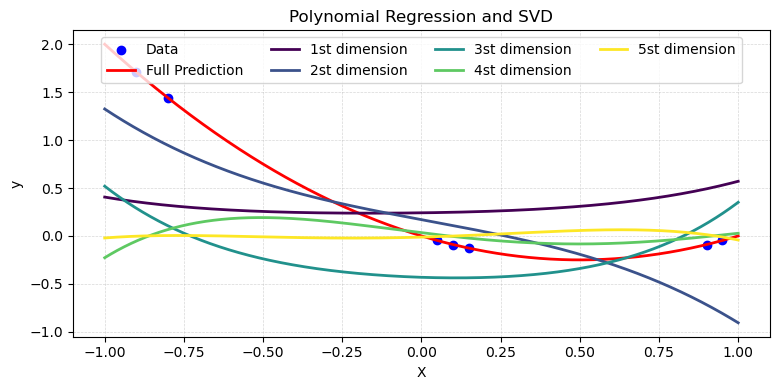

In [4]:
# Plot the data and prediction
plt.figure(figsize=(8, 4))
plt.scatter(x_training, y_training, color="blue", label="Data")
plt.plot(
    x_interval,
    y_pred.squeeze(),
    color="red",
    label="Full Prediction",
    linewidth=2,
)

color_map = cm.get_cmap("viridis", len(U))

for i in range(len(U)):
    theta_subset = (np.outer(U[:, i], U[:, i]) / s[i]) @ X_poly.T @ y
    y_pred_svd = X_pred_poly @ theta_subset
    plt.plot(
        x_interval,
        y_pred_svd.squeeze(),
        label=f"{i+1}st dimension",
        linewidth=2,
        color=color_map(i),
    )

plt.xlabel("X")
plt.ylabel("y")
plt.title("Polynomial Regression and SVD")
plt.legend(loc="upper center", ncol=4)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
num_features = 4
X_poly, y, x_interval, y_interval, x_training, y_training = create_data(num_features)
X_pred_poly = create_test_data(x_interval, num_features)
theta = fit_linear_regression(X_poly, y)
y_pred = X_pred_poly @ theta

nfs = get_pnml_normalization_factor(X_pred_poly, X_poly)

In [10]:
combs = create_subspaces_all_permutations(num_features + 1)
U, s, _ = np.linalg.svd(X_poly.T @ X_poly, hermitian=True)
Z = np.zeros((len(combs), len(y_interval), len(x_interval)))
subspace_predictions = []

for n, subspace in enumerate(combs):
    y_pred_svd, x_inv = calc_subspace_prediction(X_pred_poly, X_poly, y, U, s, subspace)
    nf = get_pnml_normalization_factor(X_pred_poly, X_poly, x_inv=x_inv)

    for i, x in enumerate(x_interval):
        mu = y_pred_svd[i].squeeze()
        var = 0.1 * nfs[i].squeeze() ** 2
        predictions = calc_gaussian_probabilities(mu, var, y_interval)
        Z[n, :, i] = predictions

    subspace_predictions.append(y_pred_svd)

Z_avg = np.mean(Z, axis=0)

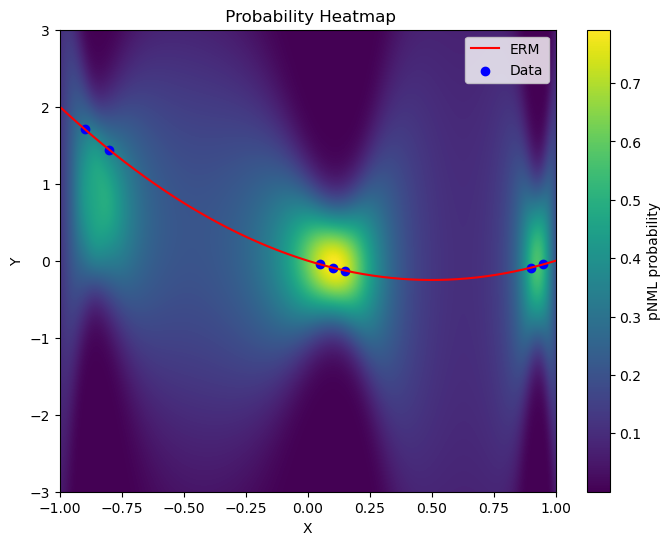

In [11]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.plot(x_interval, y_pred.squeeze(), color="red", label="ERM")
plt.scatter(x_training, y_training, color="blue", label="Data")
plt.imshow(
    Z_avg,
    extent=[x_interval[0], x_interval[-1], y_interval[0], y_interval[-1]],
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
plt.colorbar(label="pNML probability")

plt.xlabel("X")
plt.ylabel("Y")
plt.title(" Probability Heatmap")
plt.legend()
plt.show()

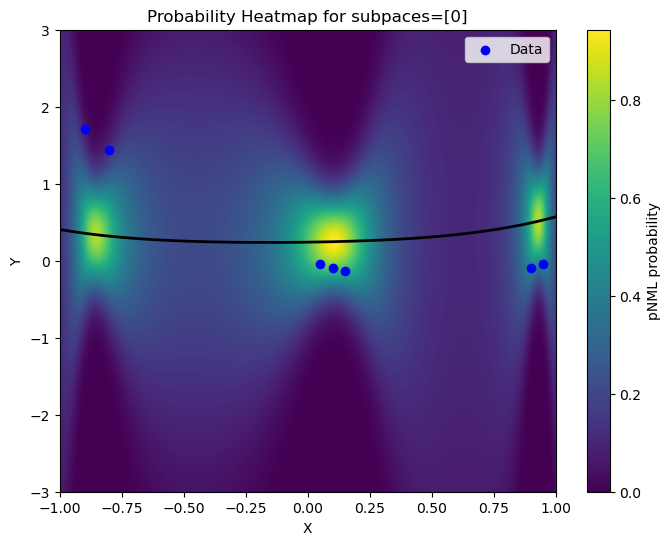

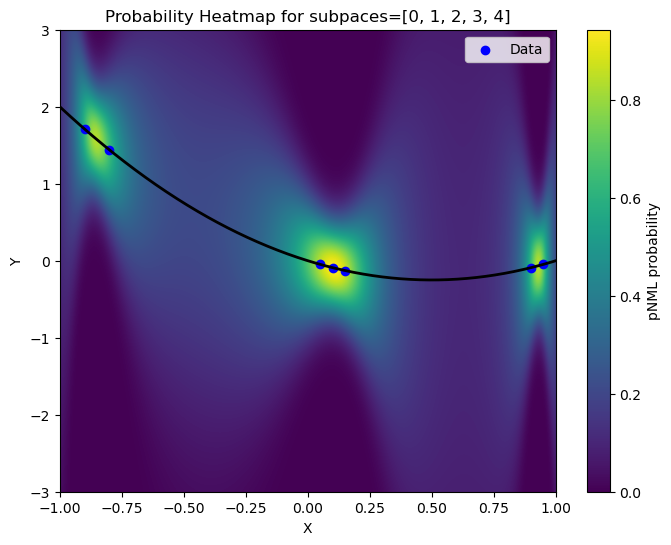

In [12]:
indices = [0, -1]

for idx in indices:
    plt.figure(figsize=(8, 6))
    plt.imshow(
        Z[idx],
        extent=[x_interval[0], x_interval[-1], y_interval[0], y_interval[-1]],
        origin="lower",
        aspect="auto",
        cmap="viridis",
    )
    plt.plot(x_interval, subspace_predictions[idx], "k-", linewidth=2)

    plt.colorbar(label="pNML probability")
    plt.scatter(x_training, y_training, color="blue", label="Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Probability Heatmap for subpaces={combs[idx]}")
    plt.legend()
    plt.show()